In [17]:
import pandas as pd
import numpy as np
import requests as req
import time
import re
import requests
import locale
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import time 

from selenium import webdriver
from tqdm import tqdm 
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from tqdm.notebook import tqdm_notebook
from collections import Counter
from itertools import chain
from requests_html import HTMLSession
from datetime import datetime, timedelta # time conversion
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.tree import plot_tree

In [39]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [38]:
# eda_df = pd.read_csv('region.csv')
# eda_df

In [133]:
# mod_df = pd.read_csv('ticket_box_cleaned.csv')
# mod_df['rr'] = mod_df['ticket']/mod_df['budget']
# mod_df = mod_df.drop(211)
# mod_df

In [5]:
# data = mod_df.loc[:,['rating','mpa','num_reviewer','region','time','rr']]

#### Processed dataset

In [32]:
data = pd.read_csv('mod_data_scaled.csv')

In [33]:
data.dtypes

rating          float64
mpa               int64
num_reviewer    float64
region            int64
time            float64
rr              float64
dtype: object

In [25]:
# data['num_reviewer'] = data['num_reviewer'].str.replace(',', '')
# data['num_reviewer'] = data['num_reviewer'].astype(float)


In [24]:
# data['mpa'] = pd.factorize(data['mpa'])[0]
# data['region'] = pd.factorize(data['region'])[0]
# data.dtypes

In [20]:
# data_scaled = data

In [21]:
# data_scaled['num_reviewer'] = preprocessing.scale(data_scaled['num_reviewer'])
# data_scaled['time'] = preprocessing.scale(data_scaled['time'])
# data_scaled['rr'] = preprocessing.scale(data_scaled['rr'])

In [34]:
data_X = data.iloc[:,1:]
data_y = data.iloc[:,0]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, random_state=208)

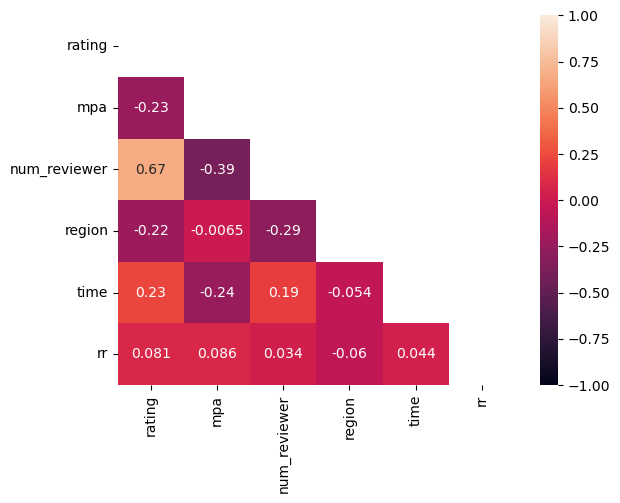

In [36]:
data_cor_mat = data.corr()

mask = np.triu(np.ones_like(data.corr(), dtype=bool))
heatmap = sns.heatmap(data.corr(), mask=mask, vmin=-1, vmax=1, annot=True)

In [98]:
data_cor_mat

,rating,mpa,num_reviewer,region,time,rr
rating,1.000000,-0.229049,0.671497,-0.219266,0.229209,0.081402
mpa,-0.229049,1.000000,-0.394898,-0.006453,-0.236537,0.085551
num_reviewer,0.671497,-0.394898,1.000000,-0.288453,0.193516,0.034406
region,-0.219266,-0.006453,-0.288453,1.000000,-0.053822,-0.059785
time,0.229209,-0.236537,0.193516,-0.053822,1.000000,0.043770
rr,0.081402,0.085551,0.034406,-0.059785,0.043770,1.000000


## Ridge CV 

In [37]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=220)
rr_mod = Ridge(alpha=1)
rr_mod.fit(X_train,y_train)
y_pred_rr = rr_mod.predict(X_test)
print('R2 score: %.6f' % r2_score(y_test,y_pred_rr))


R2 score: 0.488959


In [38]:
param = {
    'alpha':[i/10 for i in range(0, 11)]}

model = Ridge()
rr_cv = GridSearchCV(model, param, scoring='r2', n_jobs=-1, cv=cv)
result = rr_cv.fit(X_train, y_train)
print('Best Hyperparameters: %s' % result.best_params_)

Best Hyperparameters: {'alpha': 1.0}


In [49]:
rr_st = time.time()
rr_mod = Ridge(alpha=1)
rr_mod.fit(X_train,y_train)
rr_et = time.time()
print('Ridge regression runtime: %.6f' % (rr_et-rr_st))

Ridge regression runtime: 0.001567


In [40]:
y_pred_rr = result.predict(X_test)

In [41]:
print('MSE test: %.6f' % mean_squared_error(y_test, y_pred_rr))

MSE test: 0.029384


## RF 

In [51]:
rf_mod = RandomForestRegressor(n_estimators = 100, random_state = 0)
rf_st = time.time()
rf_mod.fit(X_train, y_train) 
rf_et = time.time()
print('Random Forest runtime: %.6f' % (rf_et-rf_st))

Random Forest runtime: 0.151712


In [43]:
y_pred_rf = rf_mod.predict(X_test) 

In [44]:
print('R2 score: %.6f' % r2_score(y_test,y_pred_rf))

R2 score: 0.509902


In [45]:
print('MSE test: %.6f' % mean_squared_error(y_test, y_pred_rf))

MSE test: 0.028180


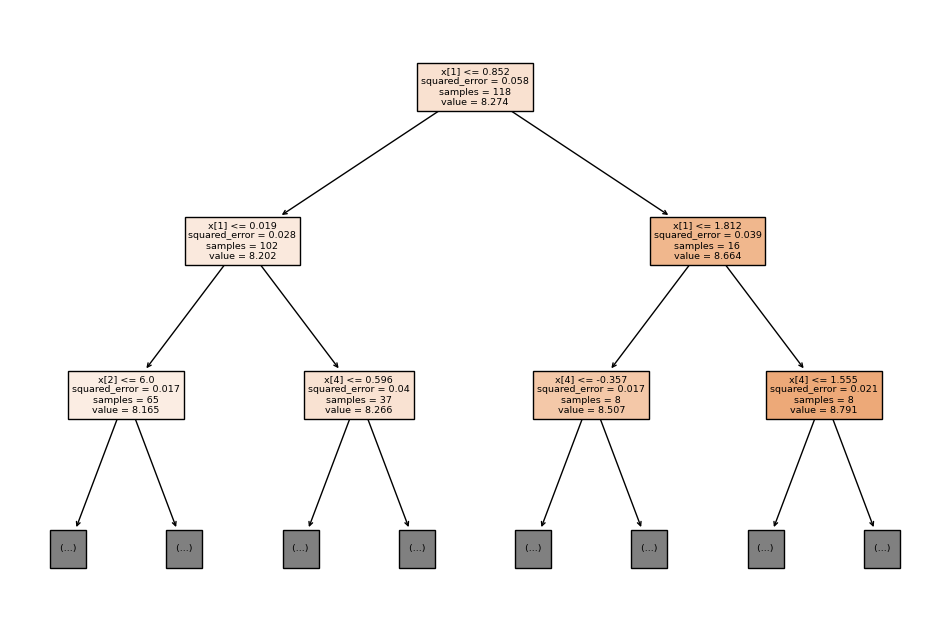

In [57]:
plt.figure(figsize=(12, 8))
plot_tree(rf_mod.estimators_[0], 
          filled=True,
         max_depth=2)
plt.show()

## Bayesian

In [59]:
clf = BayesianRidge(compute_score=True)
bayes_st = time.time()
clf.fit(X_train, y_train)
bayes_et = time.time()
print('Bayesian regression runtime: %.6f' % (bayes_et-bayes_st))

Bayesian regression runtime: 0.004007


In [47]:
y_pred_bayes = clf.predict(X_test)
print('R2 score: %.6f' % r2_score(y_test,y_pred_bayes))

R2 score: 0.488279


In [48]:
print('MSE test: %.6f' % mean_squared_error(y_test, y_pred_bayes))

MSE test: 0.029423


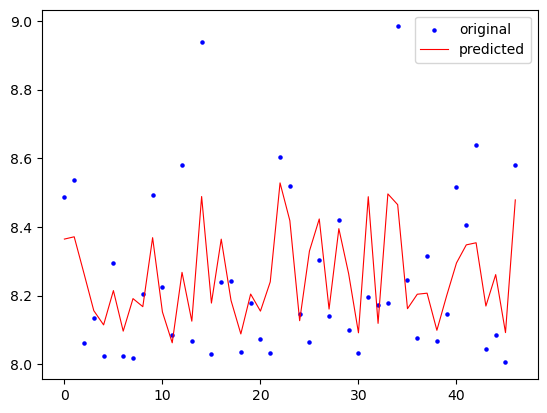

In [58]:
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred_bayes, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show() 

## Histogram of year of production 

In [132]:
# year = eda_df['year']
# plt.hist(year,
#         density=False,
#         bins = 20)
# plt.ylabel('Count')
# plt.xlabel('Year')
# plt.show()

In [43]:
# df = pd.read_csv('region.csv')


## Web scraping: list

In [2]:
# source of data are movies from imdb top 250 list
url = 'https://www.imdb.com/chart/top'
response = requests.get(url) # status check

In [3]:
response.raise_for_status

<bound method Response.raise_for_status of <Response [200]>>

In [4]:
soup = BeautifulSoup(response.text,'html.parser') # html of page of top 250 list

In [5]:
movies = soup.find_all('td',{'class':'titleColumn'})
# movie_li = [] # get all movies' titles
# for movie in movies_parents:
#     movie_li.append(movie.find('a').text)
crew = [a.attrs.get('title') for a in soup.select('td.titleColumn a')] # find text in angle parenthesisi with attr

ratings = [b.attrs.get('data-value')
        for b in soup.select('td.posterColumn span[name=ir]')] # rank and score are in posterCol

In [6]:
address = [a.attrs.get('href') for a in soup.select('td.titleColumn a')] 
# sub url of top 250

In [7]:
num_reviewer = [a.attrs.get('title') for a in soup.select('td.ratingColumn strong')]

In [8]:
list = []
 
for index in range(0, len(movies)):
     

    movie_string = movies[index].get_text()
    movie = (' '.join(movie_string.split()).replace('.', ''))
    movie_title = movie[len(str(index))+1:-7]
    year = re.search('\((.*?)\)', movie_string).group(1)
    place = movie[:len(str(index))-(len(movie))]
    
    data = {"place": place,
            "movie_title": movie_title,
            "rating": ratings[index],
            "year": year,
            "star_cast": crew[index],
            "url":address[index],
            'num_reviewer':num_reviewer[index]
            }
    list.append(data)

In [131]:
# df = pd.DataFrame(list)
# df.head()

In [130]:
# df['num_reviewer'] = df['num_reviewer'].str.split(' ', expand=True).iloc[:,3]
# df.head()

In [129]:
# cast_split_df = df['star_cast'].str.split(',',expand=True)
# df = pd.concat([df,cast_split_df],axis = 1)
# df.head()

In [128]:
# df.columns = ['rank','title','rating','year','cast','url','num_reviewer','director','star1','star2']
# df.head()

In [127]:
# df['director'] = df['director'].str.replace('\((dir.)\)', '')
# df.head()

In [23]:
# Finish scraping list, now move to scrape information for single title

In [197]:
# df.to_csv('list.csv')

In [126]:
# df['url'][:10]

## Webscraping: MPA rating 

In [148]:
mpa = [] # get mpa rating (eg. pg-13, r, etc) for each movie
    
for i in tqdm(range(df.shape[0])):
    root_url = 'https://www.imdb.com/'
    query_url = df['url'][i]
    full_url = root_url + query_url
    page = requests.get(full_url,headers={'User-Agent': 'Mozilla/5.0',
                                         'Accept-Language': 'en-US,en;q=0.8'}) # headers require
    
    soup = BeautifulSoup(page.text,'html.parser') 
    mpa_tag = soup.find_all('span', {'class': 'sc-f26752fb-2'})
    
    while(len(mpa_tag)==0):
        page = requests.get(full_url,headers={'User-Agent': 'Mozilla/5.0',
                                         'Accept-Language': 'en-US,en;q=0.8'}) # headers require
    
        soup = BeautifulSoup(page.text,'html.parser') 
        mpa_tag = soup.find_all('span', {'class': 'sc-f26752fb-2'})
        time.sleep(0.5)
#     page = requests.get(full_url,headers={'User-Agent': 'Mozilla/5.0',
#                                          'Accept-Language': 'en-US,en;q=0.8'}) # headers require
    
#     soup = BeautifulSoup(page.text,'html.parser') 
#     mpa_rating = soup.find_all('span', {'class': 'sc-f26752fb-2'})
#     time.sleep(1) # set a time out in case of unexpected break
    
#     while(len(mpa_rating)==0):
#         mpa_rating = soup.find_all('span', {'class': 'sc-f26752fb-2'})
#     # sometimes it returns none for some reason can't be explained so a while loop is set to make sure it isn't empty
    if(len(mpa_tag)==1): # in case some titles is too early to get a mpa rating
        rating_result = 'NA'
    else:
        rating_result = mpa_tag[1].text
    mpa.append(rating_result)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [09:59<00:00,  2.40s/it]


In [125]:
# df['mpa'] = mpa # get mpa rating (eg. pg-13, r, etc) for each movie
# df.head()

In [156]:
# df_to_save = df.iloc[:,1:]
# df_to_save.to_csv('mpa.csv')

## Web Scraping: Region of production 

In [420]:
pr_origin_region = [] # get mpa rating (eg. pg-13, r, etc) for each movie
    
for i in tqdm(range(df.shape[0])):
# for i in tqdm(range(10)): # test on the entire loop
    root_url = 'https://www.imdb.com/'
    query_url = df['url'][i]
    full_url = root_url + query_url
    page = requests.get(full_url,headers={'User-Agent': 'Mozilla/5.0',
                                         'Accept-Language': 'en-US,en;q=0.8'}) # headers require
    
    soup = BeautifulSoup(page.text,'html.parser') 
    parents = soup.find_all('a',{'class':'ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link'})
    
    while(len(parents)==0):
        page = requests.get(full_url,headers={'User-Agent': 'Mozilla/5.0',
                                         'Accept-Language': 'en-US,en;q=0.8'}) # headers require
    
        soup = BeautifulSoup(page.text,'html.parser') 
        parents = soup.find_all('a',{'class':'ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link'})
        time.sleep(0.5)

    for i in range(len(parents)):
        if  "/search/title/?country_of_origin" in parents[i].get('href') :
            pr_origin_region.append(parents[i].text)
            break

    

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [04:10<00:00,  1.00s/it]


In [124]:
# df['region'] = pr_origin_region
# df.head(20)

In [508]:
df_copy = df

In [123]:
# df_copy['time']=''
# df_copy.head()

## Web Scraping: Playtime 

In [518]:
playtime = [] # get mpa rating (eg. pg-13, r, etc) for each movie
    
for i in tqdm(range(df.shape[0])):
# for i in tqdm(range(10)): # test on the entire loop
    root_url = 'https://www.imdb.com/'
    query_url = df['url'][i]
    full_url = root_url + query_url
    page = requests.get(full_url,headers={'User-Agent': 'Mozilla/5.0',
                                         'Accept-Language': 'en-US,en;q=0.8'}) # headers require
    
    soup = BeautifulSoup(page.text,'html.parser') 
    parents = soup.find_all('div',{'class':'ipc-metadata-list-item__content-container'})
    
    while(len(parents)==0):
        page = requests.get(full_url,headers={'User-Agent': 'Mozilla/5.0',
                                         'Accept-Language': 'en-US,en;q=0.8'}) # headers require
        time.sleep(0.5)
        soup = BeautifulSoup(page.text,'html.parser') 
        parents = soup.find_all('div',{'class':'ipc-metadata-list-item__content-container'})
        
    for j in range(len(parents)):
        if 'hour' in parents[j].text and (len(parents[j].text)<=20): # in case it selects a comment
            time_text = parents[j].text.split()
            hh,mm = time_text[0], time_text[-2]
            total_time = int(hh)*60+int(mm)
            df_copy.iloc[i,-1]=total_time



100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [04:16<00:00,  1.03s/it]


## Web Scraping: Financial data

In [3]:
df_copy = df # get mpa rating (eg. pg-13, r, etc) for each movie
df_copy['budget_unit']=''
df_copy['budget']=''
df_copy['ticket_unit']=''
df_copy['ticket']=''

decimal_point_char = locale.localeconv()['decimal_point']

def get_li(url):
    page = requests.get(full_url,headers={'User-Agent': 'Mozilla/5.0',
                                         'Accept-Language': 'en-US,en;q=0.8'}) # headers require
    soup = BeautifulSoup(page.text,'html.parser') 
    out = soup.find_all('li',{'class':'ipc-metadata-list__item sc-6d4f3f8c-2 byhjlB'})
    return out

for i in tqdm(range(df.shape[0])):
# for i in tqdm(range(10)): # test on the entire loop
    root_url = 'https://www.imdb.com/'
    query_url = df['url'][i]
    full_url = root_url + query_url

    for k in range(5): # usually it will return a parsed page within 5 trials
        parents = get_li(full_url)
        if len(parents) !=0:
            break
    
    if len(parents) !=0:
        for j in range(len(parents)):
            budget_unit=budget_val=ticket_unit=ticket_val = -1
            if 'budget' in parents[j].text.lower():
                budget = parents[j].text
                budget_str = re.sub(r"[a-zA-Z]",'',budget)
                budget_str = re.sub(r'[\,]+', '', budget_str)
                budget_str = re.sub(r"\([^)]*\)", "", budget_str)
                budget_val = budget_str[1:-1]
                budget_unit = budget_str[0]
                df_copy.iloc[i,-4]= budget_unit
                df_copy.iloc[i,-3] = budget_val
            if 'worldwide' in parents[j].text.lower():
                ticket = parents[j].text
                ticket_str = re.sub(r"[a-zA-Z]",'',ticket)
                ticket_str = re.sub(r'[\,]+', '', ticket_str)
                ticket_str = re.sub(r"\([^)]*\)", "", ticket_str)
                ticket_val = ticket_str[2:]
                ticket_unit = ticket_str[1]
                df_copy.iloc[i,-2] = ticket_unit
                df_copy.iloc[i,-1] = ticket_val
    else:
        pass # some latest titles may not have financial data

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [03:47<00:00,  1.10it/s]


In [122]:
# df_copy.head()

In [5]:
# df_to_save = df_copy.iloc[:,1:]
# df_to_save.to_csv('ticket_box.csv',encoding='utf-8-sig')

## Test chunk

In [208]:
# # Test chunk

pr_origin_region = [] 
root_url = 'https://www.imdb.com/'
query_url = df['url'][106]
full_url = root_url + query_url

page = requests.get(full_url,headers={'User-Agent': 'Mozilla/5.0',
                                     'Accept-Language': 'en-US,en;q=0.8'}) # headers require
soup = BeautifulSoup(page.text,'html.parser') 
#     mpa_rating = soup.find_all('span', {'class': 'sc-f26752fb-2'})
# mpa_rating = soup.find_all('span', {'class': 'sc-f26752fb-2'})
# mpa_rating
# parents = soup.find_all('div',{'class':'ipc-metadata-list-item__content-container'})
# parents = soup.find_all('a',{'class':'ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link'})
# # len(parents)
# for i in range(len(parents)):
#     if  "/search/title/?country_of_origin" in parents[i].get('href') :
# #         temp_li = []
# #         temp_li.append(parents[i].text)
# #         pr_origin_region.append((temp_li))
#         print((parents[i].text))
#         break
parents = soup.find_all('li',{'class':'ipc-metadata-list__item sc-6d4f3f8c-2 byhjlB'})
# for i in range(len(parents)):
#     if 'Budget' in parents[i].text:
#         budget = parents[i].text
#         budget_str = re.sub(r"[a-zA-Z]",'',budget)
#         budget_str = re.sub(r'[\,]+', '', budget_str)
#         budget_str = re.sub(r"\([^)]*\)", "", budget_str)
#         budget_val = budget_str[1:]
#         budget_unit = budget_str[0]
#         print(budget_unit,budget_val)
parents

[]